## Config

In [2]:
# Install dependencies
!pip install -q diffusers transformers torch torchvision numpy opencv-python pillow matplotlib tqdm scikit-image scipy safetensors


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.0 MB/s eta 0:00:00


## MultiStage inpainting pipeline

In [3]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline
from skimage.metrics import structural_similarity as ssim
import torchvision.transforms as T
import os
from IPython.display import display, clear_output
from tqdm.notebook import tqdm
import ipywidgets as widgets

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
def initialize_sd_pipeline():
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        safety_checker=None,
        requires_safety_checking=False
    ).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    return pipe


In [5]:
#@title OneFormer
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
import torch
from PIL import Image
import numpy as np

class OneFormerMaskGenerator:
    def __init__(self):
        self.processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_ade20k_swin_large")
        self.model = OneFormerForUniversalSegmentation.from_pretrained("shi-labs/oneformer_ade20k_swin_large")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        self.model.eval()

        # Define background classes (architectural elements to exclude)
        self.background_classes = [0, 1, 3, 5, 4, 6, 8, 9, 14, 38]  # 0 is original background

    def generate_mask(self, image_path):
        """Generate mask using OneFormer model"""
        image = Image.open(image_path).convert('RGB')

        inputs = self.processor(images=image, task_inputs=["semantic"], return_tensors="pt")
        inputs = {k: v.to(self.device) if hasattr(v, "to") else v for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)

        segmentation_maps = self.processor.post_process_semantic_segmentation(
            outputs,
            target_sizes=[(image.size[1], image.size[0])]
        )[0]

        segmentation = segmentation_maps.cpu().numpy()

        # Create foreground mask
        foreground_mask = np.ones_like(segmentation, dtype=np.uint8) * 255
        for bg_class in self.background_classes:
            foreground_mask[segmentation == bg_class] = 0

        # Save mask
        mask_path = os.path.splitext(image_path)[0] + "_foreground_mask.png"
        Image.fromarray(foreground_mask).save(mask_path)

        return mask_path

## Inpainting pipeline

In [6]:
class InpaintingPipeline:
    def __init__(self, pipe):
        self.pipe = pipe
        self.setup_prompts()
        self.mask_generator = OneFormerMaskGenerator();

    def setup_prompts(self):
        self.prompts = [
            "empty room", "empty space uniformly blank",
            "unfurnished room straight edges",
            "empty room uniformly blank straight edges",
            "completely empty room",
            "A photo of an empty room with bare walls, clean floor, and no furniture or objects.",
            "Remove everything from the room except the walls, windows, doors and floor.",
            "Fill in the missing areas with structural background only, preserving the room's geometry. Do not generate furniture, decorations, or any identifiable objects. Maintain a uniform surface for walls, floors, and ceilings, blending seamlessly with the existing structure."
            ]


        self.negative_prompt = (
            "furniture, chairs, tables, beds, couches, sofas, cabinets, "
            "decorations, pillows, carpets, rugs, curtains, drapes, "
            "plants, vases, paintings, picture frames, wall art"
        )

    def process_png_mask(self, image_path, mask_path):
        empty_room = Image.open(image_path).convert('RGB').resize((512, 512))
        mask = Image.open(mask_path).convert('L').resize((512, 512))
        mask_array = np.array(mask)
        mask_array = cv2.dilate((mask_array > 127).astype(np.uint8), np.ones((3,3)), iterations=10) * 255
        return empty_room, Image.fromarray(mask_array)

    def generate_variations(self, image, mask_image, num_variations=5, seed=42):
        results = []
        for iteration in tqdm(range(num_variations), desc="Generating variations"):
            torch.manual_seed(seed + iteration) # Seed incremented for each variation
            output = self.pipe(
                prompt=self.prompts[iteration % len(self.prompts)],
                negative_prompt=self.negative_prompt,
                image=image,
                mask_image=mask_image,
                num_inference_steps=100,
                guidance_scale=7.5 + iteration * 2.5,
                cross_attention_kwargs={"scale": 0.8}
            )
            results.append(output.images[0])
        return results

    def display_and_select(self, variations):
        from google.colab import output
        output.clear()

        plt.figure(figsize=(20, 4))
        for i, img in enumerate(variations):
            plt.subplot(1, len(variations), i + 1)
            plt.imshow(img)
            plt.title(f'Variation {i}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

        from IPython.display import HTML
        from google.colab import output

        # Create HTML buttons
        buttons_html = """
        <div style="margin: 10px;">
        """
        for i in range(len(variations)):
            buttons_html += f"""
            <button id="btn_{i}"
                    style="margin: 5px; padding: 10px 20px;"
                    onclick="window.selected_variation={i}">
                Select Variation {i}
            </button>
            """
        buttons_html += "</div>"

        # JavaScript to handle selection
        js = """
        <script>
        window.selected_variation = null;
        async function wait_for_selection() {
            while (window.selected_variation === null) {
                await new Promise(r => setTimeout(r, 100));
            }
            var selection = window.selected_variation;
            window.selected_variation = null;
            return selection;
        }
        </script>
        """

        display(HTML(js + buttons_html))

        # Get selection using JavaScript evaluation
        from google.colab import output
        selection = output.eval_js('wait_for_selection()')

        print(f"Selected variation {selection}")
        return variations[selection]

    def ask_continue(self):
        from IPython.display import HTML
        from google.colab import output

        buttons_html = """
        <div style="margin: 10px;">
            <button id="btn_yes"
                    style="margin: 5px; padding: 10px 20px;"
                    onclick="window.continue_choice=true">
                Yes, generate new mask
            </button>
            <button id="btn_no"
                    style="margin: 5px; padding: 10px 20px;"
                    onclick="window.continue_choice=false">
                No, stop here
            </button>
        </div>
        """

        js = """
        <script>
        window.continue_choice = null;
        async function wait_for_continue_choice() {
            while (window.continue_choice === null) {
                await new Promise(r => setTimeout(r, 100));
            }
            var choice = window.continue_choice;
            window.continue_choice = null;
            return choice;
        }
        </script>
        """

        display(HTML(js + buttons_html))

        choice = output.eval_js('wait_for_continue_choice()')
        return choice

    def run_pipeline(self, image_path):
        print("Stage 1: Generating initial mask and variations")
        # Generate the initial mask using OneFormer
        initial_mask_path = self.mask_generator.generate_mask(image_path)

        # Save a copy of the initial mask with a more descriptive name
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        initial_mask_copy = f"initial_mask_{base_name}.png"
        Image.open(initial_mask_path).save(initial_mask_copy)
        print(f"Saved initial mask as: {initial_mask_copy}")

        # Process the image and mask
        image, mask = self.process_png_mask(image_path, initial_mask_path)
        variations = self.generate_variations(image, mask)

        iteration = 1
        while True:
            clear_output(wait=True)
            print(f"Iteration {iteration}")
            selected_image = self.display_and_select(variations)
            selected_image.save(f"iteration_{iteration}.png")

            if not self.ask_continue():
                print("Pipeline completed!")
                break

            print("\nStage 2: Generating new mask")
            # mask_generator = MaskGenerator()
            # new_mask_path = mask_generator.generate_mask(f"iteration_{iteration}.png")
            new_mask_path = self.mask_generator.generate_mask(f"iteration_{iteration}.png")


            print("\nStage 3: Processing with PNG mask")
            image, mask = self.process_png_mask(f"iteration_{iteration}.png", new_mask_path)
            variations = self.generate_variations(image, mask)
            iteration += 1


## Ingest the input

In [7]:
#@title Download Resources Folder using wget
# Create directory for resources
!mkdir -p resources

# Define the files you need to download from your structure
files = [
    "notes.md",
    "room_object_masks.npz",
    "room_objects.png",
    "room_objects_foreground.png",
    "inference_sd_no_fine_tuning.ipynb"
]

# Base URL for the raw files
base_url = "https://raw.githubusercontent.com/lsunol/casalimpia/main/models-and-research/inference/sd_no_fine-tuning/resources"

# Download each file
for file in files:
    !wget -q "$base_url/$file" -O "resources/$file"
    print(f"Downloaded {file}")

print("Resources folder has been downloaded successfully!")


Downloaded notes.md
Downloaded room_object_masks.npz
Downloaded room_objects.png
Downloaded room_objects_foreground.png
Downloaded inference_sd_no_fine_tuning.ipynb
Resources folder has been downloaded successfully!


In [8]:
sd_pipe = initialize_sd_pipeline()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Keyword arguments {'requires_safety_checking': False} are not expected by StableDiffusionInpaintPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
pipeline = InpaintingPipeline(sd_pipe)

preprocessor_config.json:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `OneFormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


ade20k_panoptic.json:   0%|          | 0.00/7.08k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/84.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/880M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/879M [00:00<?, ?B/s]

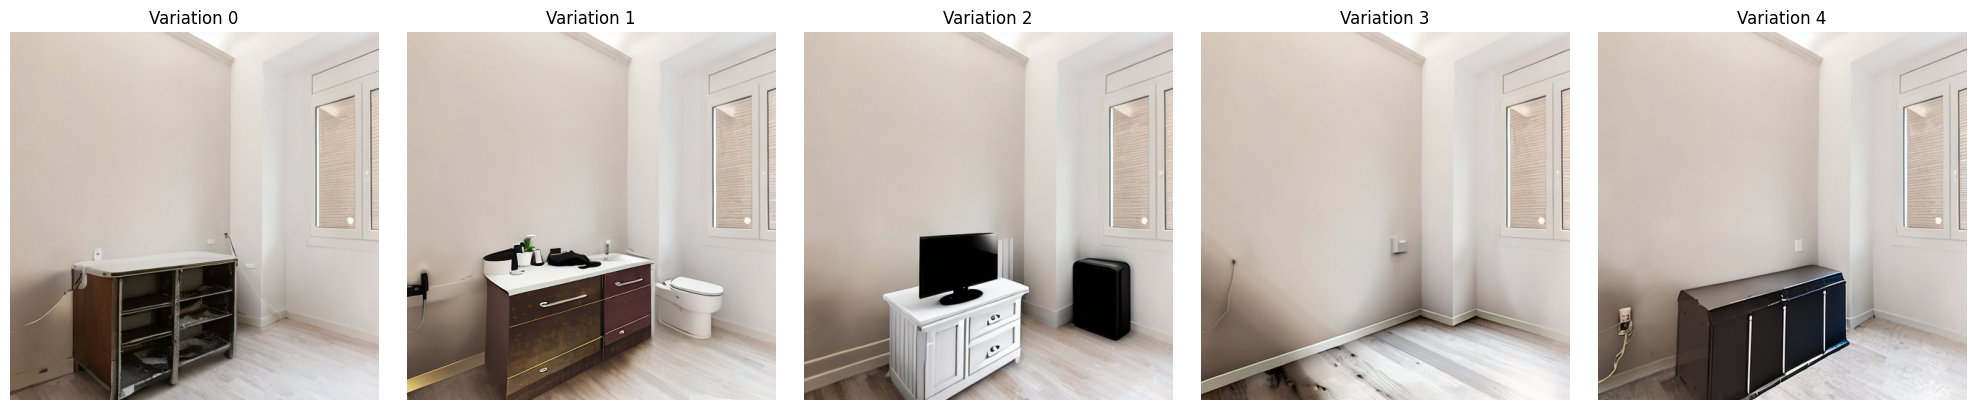

KeyboardInterrupt: 

In [10]:
pipeline.run_pipeline("/content/resources/room_objects.png")

In [ ]:
for name, param in sd_pipe.unet.named_parameters():
    if 'lora' in name.lower():
        print(name, param.shape)

In [ ]:
rm -r casalimpia-colab-inference_sd_no_fine_tuning/